In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import bisect
import seaborn as sns
import math

plt.style.use('ggplot')

In [2]:
def evaluate_peak_detection(detected_peaks, annotated_peaks, tolerance=10):
    detected_peaks = sorted(detected_peaks)
    annotated_peaks = sorted(annotated_peaks)
   
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_annotated = set()

    for peak in detected_peaks:
        idx = bisect.bisect_left(annotated_peaks, peak)
        for i in range(max(0, idx - 1), min(len(annotated_peaks), idx + 2)):
            if abs(peak - annotated_peaks[i]) <= tolerance:
                true_positives += 1
                matched_annotated.add(i)
                break
        else:
            false_positives += 1

    false_negatives = len(annotated_peaks) - len(matched_annotated)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    confusion_mat = [
        [true_positives, false_positives],
        [false_negatives, 0]
    ]

    return {
        "TP": true_positives,
        "FP": false_positives,
        "FN": false_negatives,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Confusion Matrix": confusion_mat
    }

def high_pass_filter(signal, samp_rate, cutoff_freq=40):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def get_file(path="database/train/drive01", sampfrom=0, n_samp=500, filter=True, do_sample=True):
    if do_sample:
        sig, sinfo = wfdb.rdsamp(path, sampfrom=sampfrom, sampto=sampfrom+n_samp)
    else:
        sig, sinfo = wfdb.rdsamp(path)
    sig = sig[:, 0].flatten()

    if filter:
        sig = high_pass_filter(sig, sinfo["fs"])

    sinfo["record_name"] = os.path.basename(path)

    dir_name, record_name = os.path.split(path)
    annotation_path = os.path.join(dir_name, f"{record_name}.atr")
    
    if os.path.isfile(annotation_path):
        if do_sample:
            ann = wfdb.rdann(path, extension='atr', sampfrom=sampfrom, sampto=sampfrom+n_samp)
        else:
            ann = wfdb.rdann(path, extension='atr')
        sinfo['annotation'] = ann
    else:
        sinfo['annotation'] = None

    return sig, sinfo

def load_train_data(folder="database/train", sampfrom=0, n_samp=500, filter=True,do_sample=True):
    signals = []
    info = []

    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)

        if os.path.isfile(file_path) and file_name.startswith("drive") and file_name.endswith(".dat"):
            file_without_extension = os.path.splitext(file_name)[0]
            new_file_name = f"{folder}/{file_without_extension}"
            sig, sinfo = get_file(new_file_name, sampfrom=sampfrom, n_samp=n_samp, filter=filter, do_sample=do_sample)
            
            signals.append(sig)
            info.append(sinfo)

    return signals, info

def load_test_data(folder="database/test", sampfrom=0, n_samp=500, filter=True, do_sample=True):
    signals = []
    info = []

    records_file = os.path.join(folder, "RECORDS")
    with open(records_file, "r") as file:
        records = [line.strip() for line in file.readlines()]

    for record in records:
        file_path = os.path.join(folder, record)
        
        if os.path.isfile(f"{file_path}.dat"):
            sig, sinfo = get_file(file_path, sampfrom=sampfrom, n_samp=n_samp, filter=filter, do_sample=do_sample)
            
            signals.append(sig)
            info.append(sinfo)

    return signals, info

def detect_peaks(signal, p_threshold, min_distance=3, min_peak_height=0.01):
    threshold = np.percentile(signal, p_threshold)
    
    above_threshold = signal > threshold
    diff = np.diff(above_threshold.astype(int))
    rise = np.where(diff == 1)[0] + 1 
    fall = np.where(diff == -1)[0] + 1 
    
    if above_threshold[0]:
        rise = np.insert(rise, 0, 0)
    if above_threshold[-1]:
        fall = np.append(fall, len(signal))
    
    peaks = []
    peaks_values = []
    for start, end in zip(rise, fall):
        segment = signal[start:end]
        if len(segment) == 0:
            continue
        max_idx = np.argmax(segment)
        peak_idx = start + max_idx
        peaks.append(peak_idx)
        peaks_values.append(signal[peak_idx])
    
    if min_distance > 0:
        peaks = np.array(peaks)
        peaks_values = np.array(peaks_values)
        sorted_indices = np.argsort(peaks_values)[::-1]
        sorted_peaks = peaks[sorted_indices]
        
        filtered_peaks = []
        used = np.zeros(len(signal), dtype=bool)
        
        for peak in sorted_peaks:
            if used[peak]:
                continue
            start = max(0, peak - min_distance)
            end = min(len(signal), peak + min_distance + 1)
            if not used[start:end].any():
                filtered_peaks.append(peak)
                used[start:end] = True
        
        filtered_peaks = np.sort(filtered_peaks)
        peaks = filtered_peaks.tolist()
        peaks_values = signal[filtered_peaks].tolist()
    
    if min_peak_height is not None:
        peaks = [peak for peak in peaks if signal[peak] >= min_peak_height]
        peaks_values = [signal[peak] for peak in peaks]
    
    return np.array(peaks), np.array(peaks_values)

def bpm(signal, signal_info, peaks):
    beats = len(peaks)
    mins = len(signal)/(signal_info["fs"]*60)
    return round(beats/mins, 1)

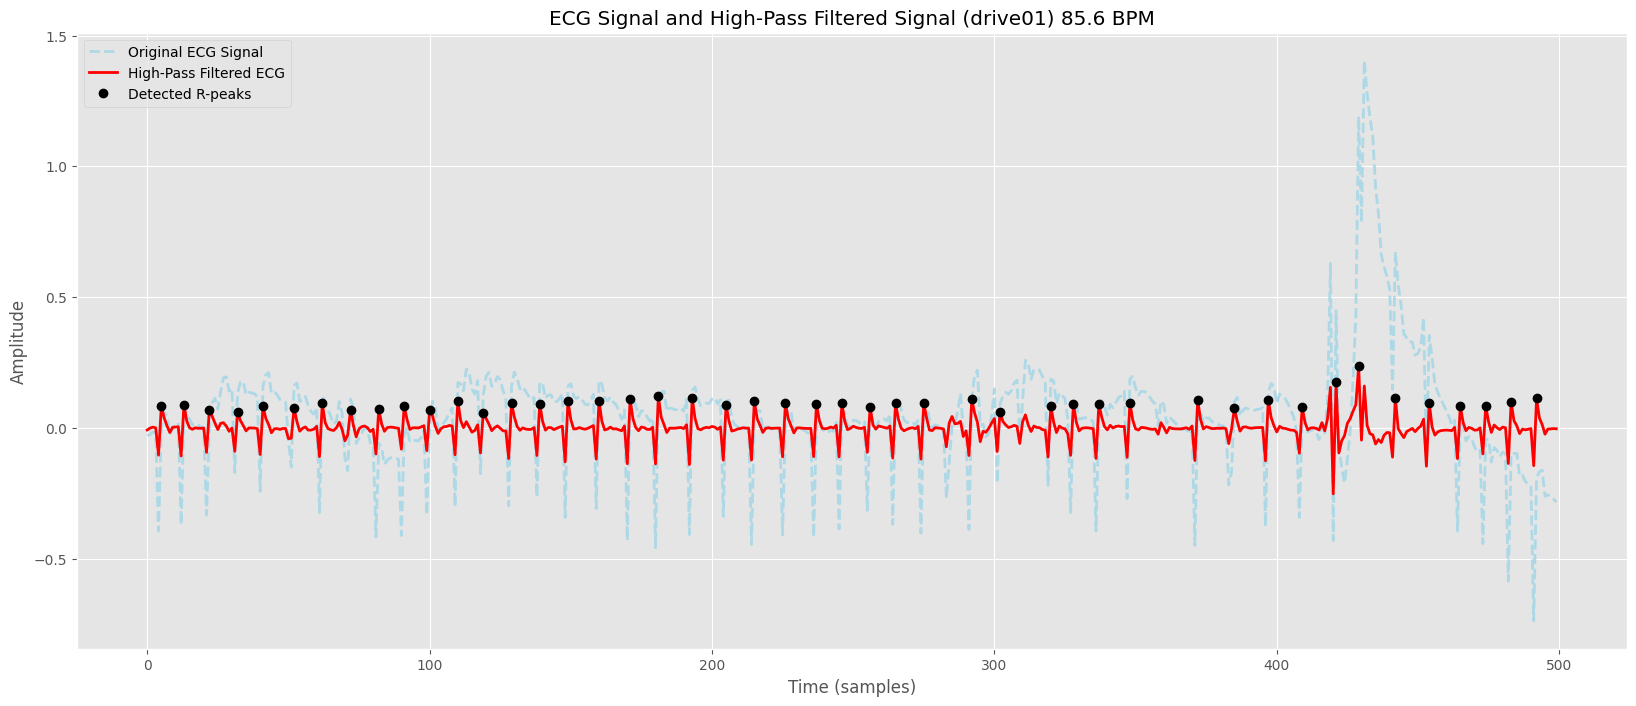

In [3]:
samples = 500
test_ecg, test_fields = get_file(n_samp=samples,filter=False)
filtered_test_ecg, filtered_test_fields = get_file(filter=True)
peaks, values = detect_peaks(filtered_test_ecg, 90, min_distance=3)

plt.figure(figsize=(20,8))
plt.plot(test_ecg, label='Original ECG Signal', color='lightblue', linestyle='--', linewidth=2)
plt.plot(filtered_test_ecg, label='High-Pass Filtered ECG', color='red', linestyle='-', linewidth=2)
plt.plot(peaks, values, 'o', color="black", label='Detected R-peaks')
plt.title(f'ECG Signal and High-Pass Filtered Signal (drive01) {bpm(filtered_test_ecg, filtered_test_fields, peaks)} BPM')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc="upper left")
plt.show()

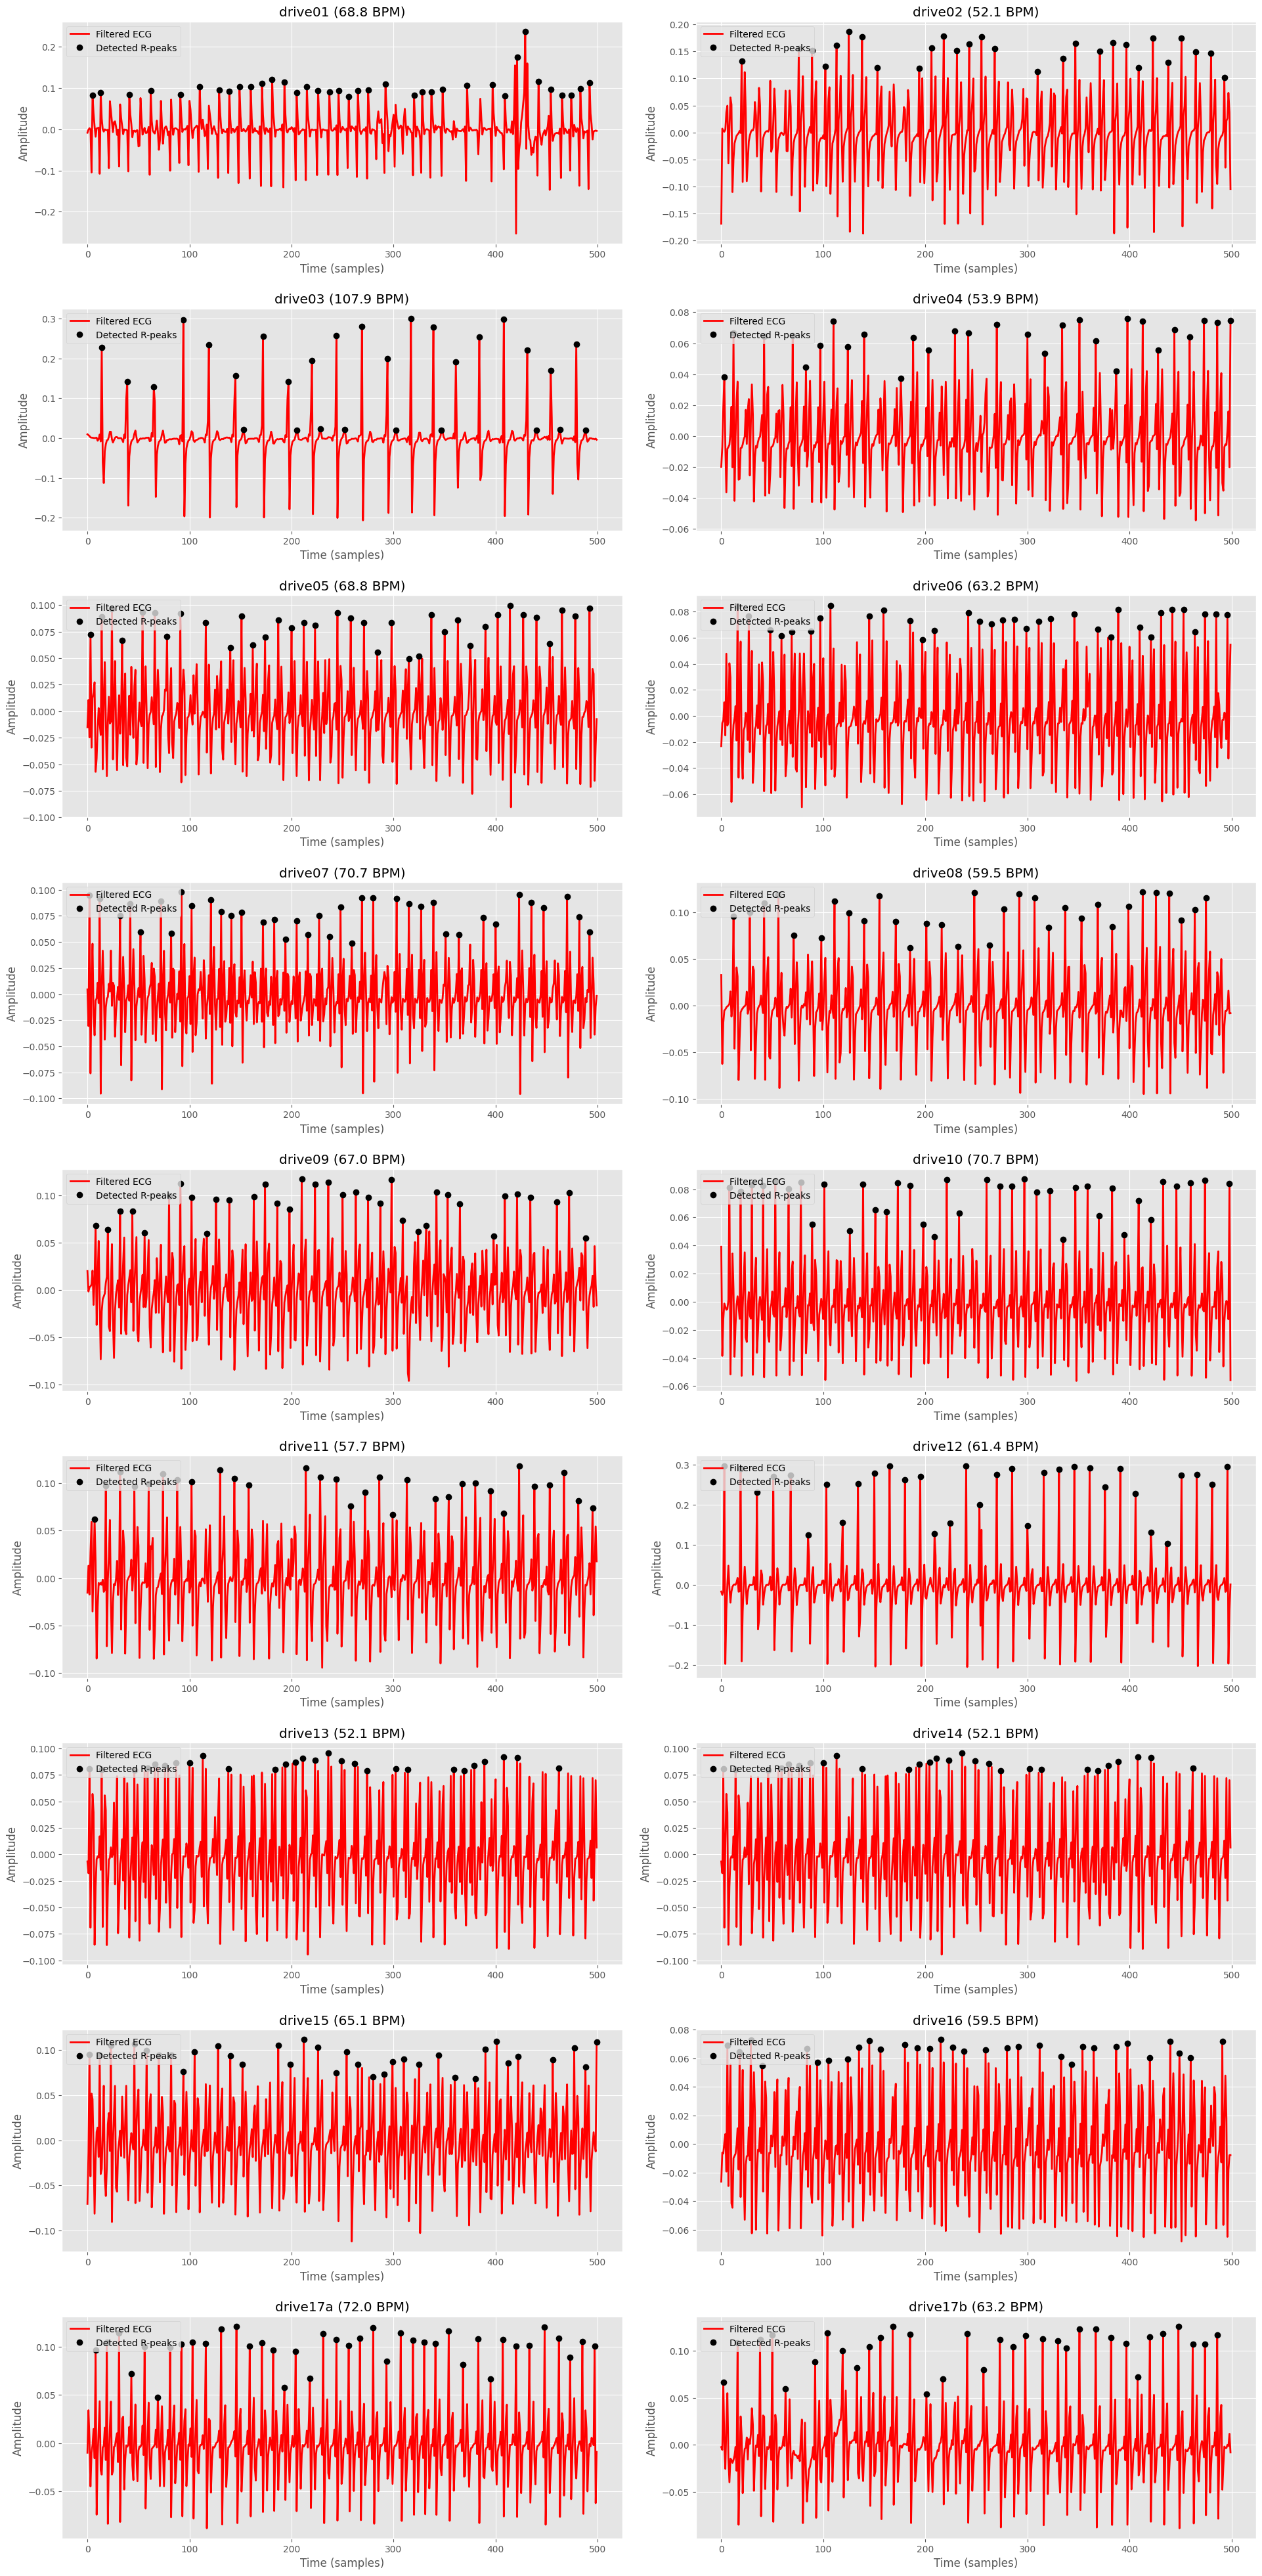

In [4]:
sample = 500
all_train_signals, all_train_infos = load_train_data(n_samp=samples)

rows, cols = 9, 2
total_plots = rows * cols


fig, axes = plt.subplots(rows, cols, figsize=(20, 40))
fig.tight_layout(pad=5.0)

for i, (signal, info) in enumerate(zip(all_train_signals, all_train_infos)):

    peaks, values = detect_peaks(signal, 92)
    ax = axes[i // cols, i % cols]

    ax.plot(signal, label="Filtered ECG", color="red", linestyle="-", linewidth=2)
    ax.plot(peaks, values, "o", color="black", label="Detected R-peaks")
    ax.set_title(f"{info['record_name']} ({bpm(signal, info, peaks)} BPM)")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper left")

plt.show()


In [5]:
test_signals, test_info = load_test_data(folder="database/test", filter=True, do_sample=False)

results = []
for signal, info in zip(test_signals, test_info):
        peaks, _ = detect_peaks(signal, 95, min_distance=6)
        heart_rate = bpm(signal, info, peaks)

        results.append({
            "file": info["record_name"],
            "bpm": heart_rate,
            "peaks": peaks,
            "peaks_length": len(peaks),
        })

df = pd.DataFrame(results)
df


,file,bpm,peaks,peaks_length
0,16265,97.7,"[53, 131, 208, 286, 365, 426, 443, 505, 523, 5...",149293
1,16272,128.7,"[60, 74, 186, 200, 309, 323, 432, 446, 554, 56...",193108
2,16273,97.4,"[10, 72, 88, 149, 166, 226, 243, 320, 382, 398...",144057
3,16420,117.6,"[51, 70, 131, 150, 213, 230, 296, 312, 379, 39...",169261
4,16483,120.8,"[16, 40, 96, 120, 176, 255, 281, 335, 415, 494...",188185
5,16539,135.8,"[72, 168, 268, 364, 454, 543, 637, 746, 866, 9...",200291
6,16773,93.9,"[52, 79, 158, 185, 265, 290, 366, 392, 468, 57...",135085
7,16786,107.3,"[14, 88, 118, 196, 306, 334, 410, 438, 517, 62...",157714
8,16795,75.6,"[14, 121, 151, 233, 263, 346, 470, 502, 591, 6...",106905
9,17052,110.6,"[38, 152, 189, 267, 304, 377, 487, 603, 716, 8...",153549


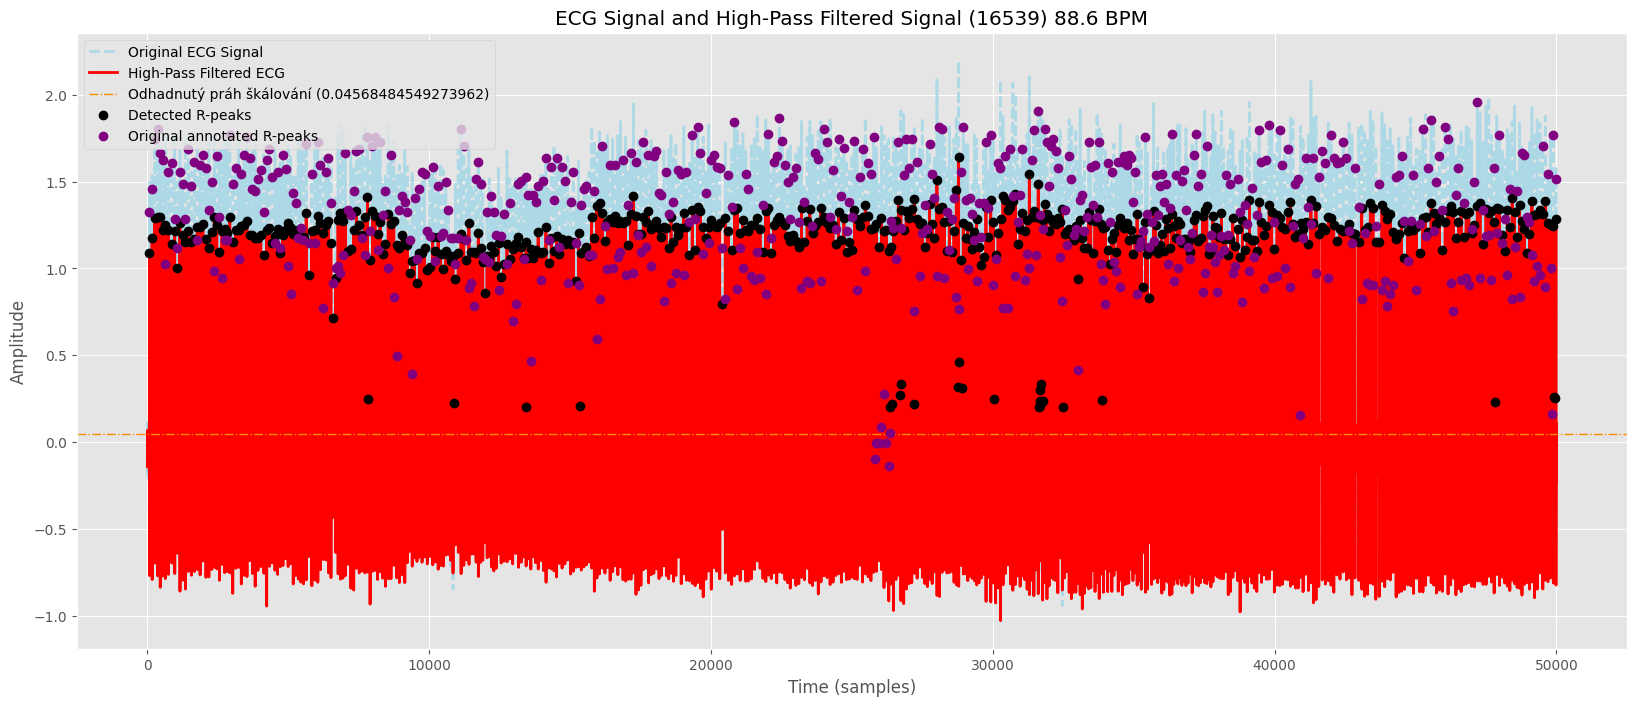

In [6]:
samples = 50000
test_ecg, test_fields = get_file("database/test/16539", n_samp=samples,filter=False)
filtered_test_ecg, filtered_test_fields = get_file("database/test/16539", n_samp=samples,filter=True)
peaks, values = detect_peaks(filtered_test_ecg, 95, min_peak_height=0.2)

annotated_peaks = test_fields["annotation"].sample
annotated_peak_values = test_ecg[annotated_peaks]

plt.figure(figsize=(20,8))
plt.plot(test_ecg, label='Original ECG Signal', color='lightblue', linestyle='--', linewidth=2)
plt.plot(filtered_test_ecg, label='High-Pass Filtered ECG', color='red', linestyle='-', linewidth=2)
plt.axhline(np.percentile(signal, 92), linestyle="-.", lw=1, color="#f78c00", label=f"Odhadnutý práh škálování ({np.percentile(signal, 92)})")
plt.plot(peaks, values, 'o', color="black", label='Detected R-peaks')
plt.plot(annotated_peaks, annotated_peak_values, 'o', color="purple", label='Original annotated R-peaks')
plt.title(f'ECG Signal and High-Pass Filtered Signal ({test_fields["record_name"]}) {bpm(filtered_test_ecg, filtered_test_fields, peaks)} BPM')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc="upper left")
plt.show()

File: 16265 | TP: 100963, FP: 3300, FN: 414 | Precision: 0.97, Recall: 1.00, F1-Score: 0.98
File: 16272 | TP: 98492, FP: 14122, FN: 4312 | Precision: 0.87, Recall: 0.96, F1-Score: 0.91
File: 16273 | TP: 90544, FP: 8578, FN: 162 | Precision: 0.91, Recall: 1.00, F1-Score: 0.95
File: 16420 | TP: 102980, FP: 2405, FN: 282 | Precision: 0.98, Recall: 1.00, F1-Score: 0.99
File: 16483 | TP: 108187, FP: 17013, FN: 109 | Precision: 0.86, Recall: 1.00, F1-Score: 0.93
File: 16539 | TP: 109565, FP: 7138, FN: 298 | Precision: 0.94, Recall: 1.00, F1-Score: 0.97
File: 16773 | TP: 109054, FP: 16894, FN: 4926 | Precision: 0.87, Recall: 0.96, F1-Score: 0.91
File: 16786 | TP: 101776, FP: 9113, FN: 76 | Precision: 0.92, Recall: 1.00, F1-Score: 0.96
File: 16795 | TP: 114147, FP: 4320, FN: 692 | Precision: 0.96, Recall: 0.99, F1-Score: 0.98
File: 17052 | TP: 88156, FP: 2520, FN: 372 | Precision: 0.97, Recall: 1.00, F1-Score: 0.98
File: 17453 | TP: 103183, FP: 7427, FN: 367 | Precision: 0.93, Recall: 1.00, F1

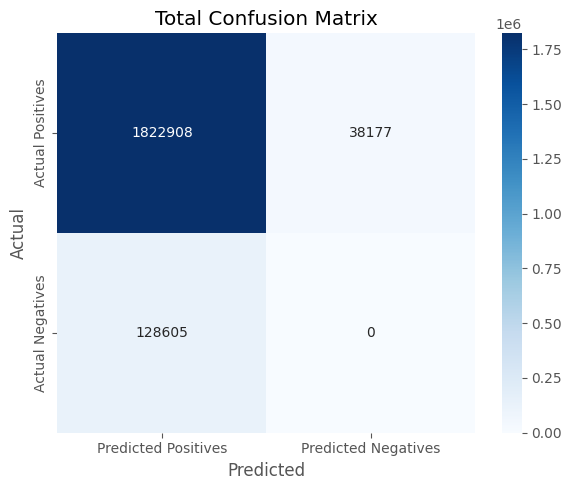

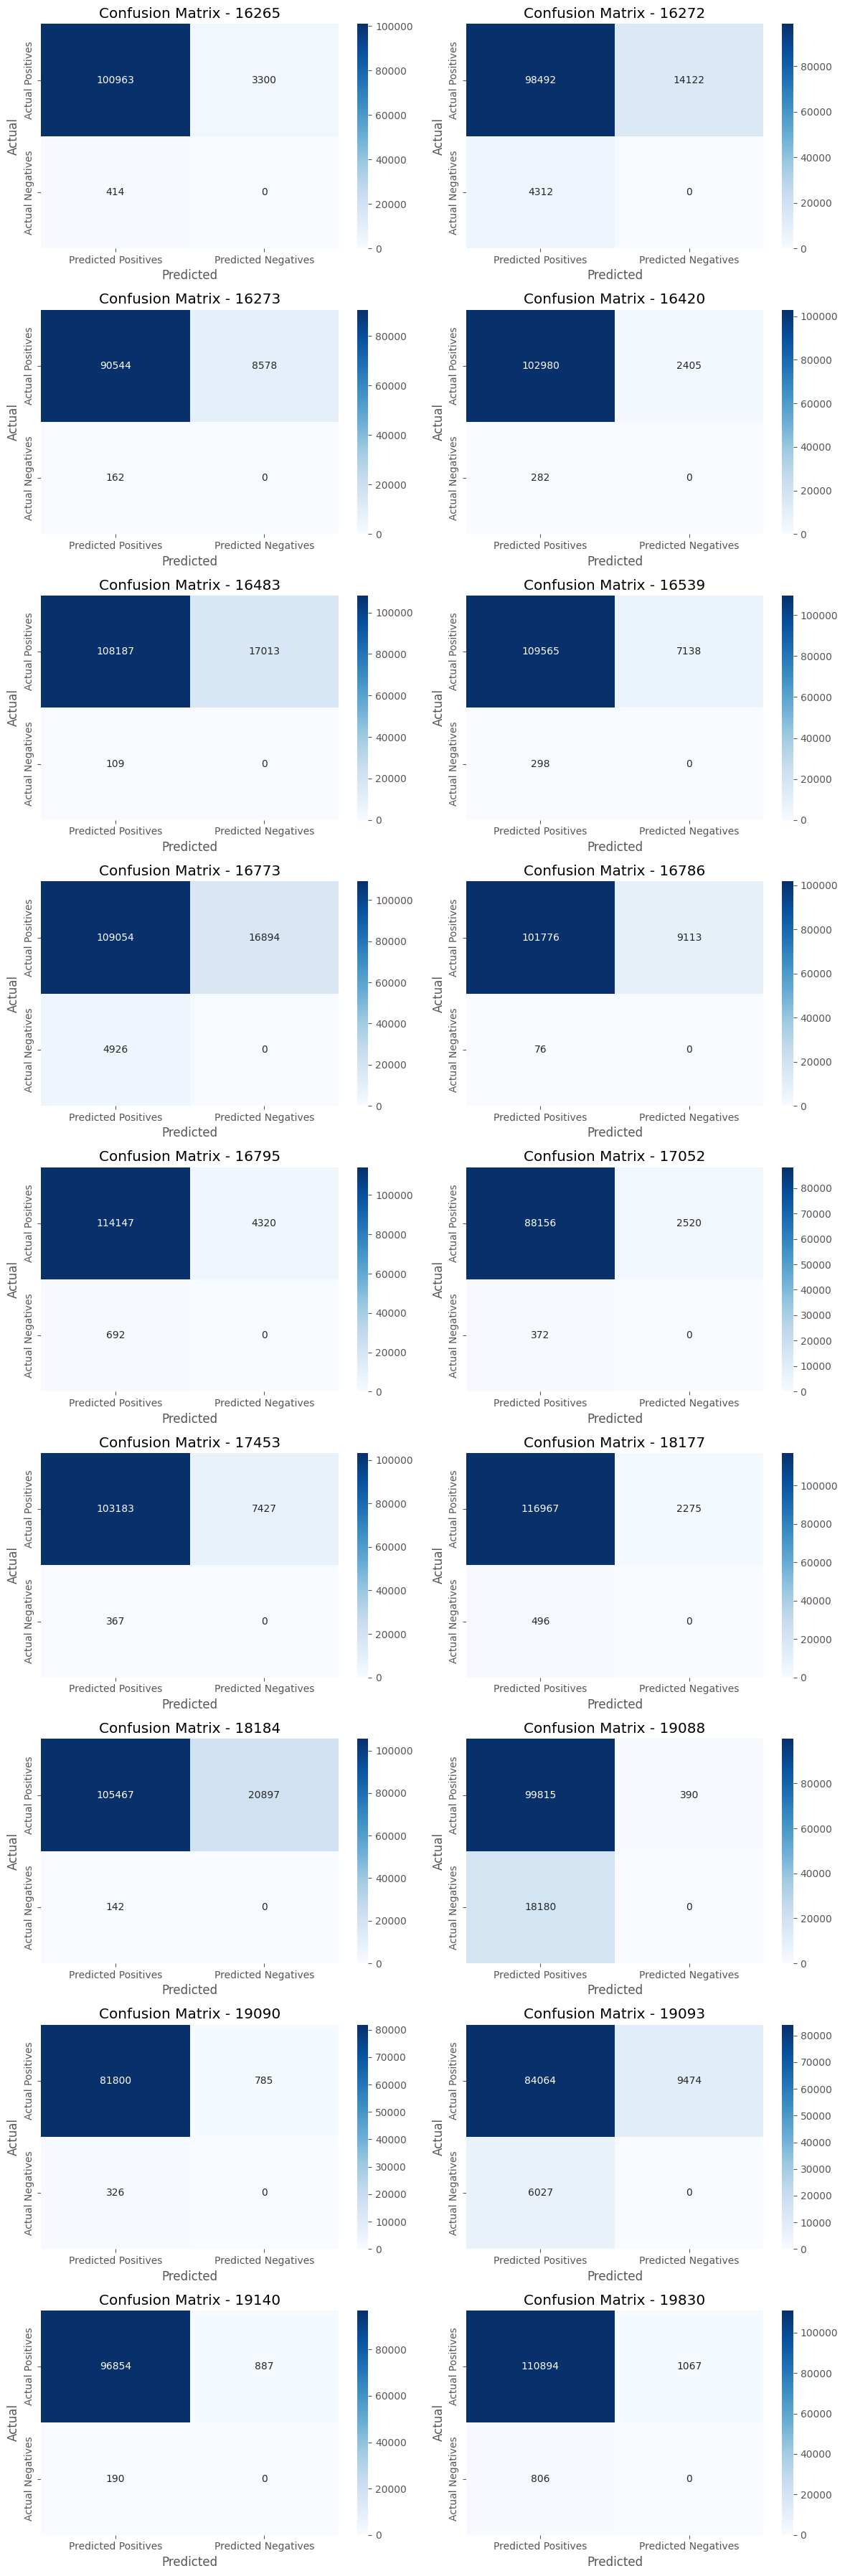

In [7]:
# Initialize variables to accumulate metrics and totals
total_precision, total_recall, total_f1 = 0, 0, 0
total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0
num_files = len(test_signals)

# First loop: Process signals, calculate metrics, and print results
metrics_list = []  # To store metrics for heatmap plotting later
for idx, (signal, info) in enumerate(zip(test_signals, test_info)):
    # Detect R peaks
    detected_peaks, _ = detect_peaks(signal, 94, min_peak_height=0.2)

    # Load annotated peaks
    record_name = info["record_name"]
    file_path = f"database/test/{record_name}"
    annotated_filter_peaks = info["annotation"].sample

    # Evaluate accuracy
    metrics = evaluate_peak_detection(detected_peaks, annotated_filter_peaks, tolerance=15)

    # Accumulate metrics for average calculation
    total_precision += metrics["Precision"]
    total_recall += metrics["Recall"]
    total_f1 += metrics["F1-Score"]

    # Accumulate totals for the confusion matrix
    total_tp += metrics["TP"]
    total_fp += metrics["FP"]
    total_fn += metrics["FN"]
    total_tn += 0

    # Store metrics and record name for later use
    metrics_list.append((metrics, record_name))

    # Display results
    print(f"File: {record_name} | TP: {metrics['TP']}, FP: {metrics['FP']}, FN: {metrics['FN']} | Precision: {metrics['Precision']:.2f}, Recall: {metrics['Recall']:.2f}, F1-Score: {metrics['F1-Score']:.2f}")

# Calculate and display average accuracy
avg_precision = total_precision / num_files
avg_recall = total_recall / num_files
avg_f1 = total_f1 / num_files
print(f"\nAverage Metrics: Precision: {avg_precision:.2f}, Recall: {avg_recall:.2f}, F1-Score: {avg_f1:.2f}")

# Create a total confusion matrix
total_confusion_matrix = [[total_tp, total_fn], [total_fp, total_tn]]

# Plot the total stats heatmap as a separate plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    total_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Positives", "Predicted Negatives"],
    yticklabels=["Actual Positives", "Actual Negatives"]
)
plt.title("Total Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Create subplots for individual heatmaps
num_cols = 2
num_rows = math.ceil(num_files / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
axes = axes.flatten()

# Plot individual heatmaps for each file
for idx, (metrics, record_name) in enumerate(metrics_list):
    sns.heatmap(
        metrics["Confusion Matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Positives", "Predicted Negatives"],
        yticklabels=["Actual Positives", "Actual Negatives"],
        ax=axes[idx]
    )
    axes[idx].set_title(f"Confusion Matrix - {record_name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Turn off unused subplots if necessary
for i in range(num_files, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()
